## Env Variables

In [95]:
plain_image_path = "../Dataset/Train Images/Plain/"
plain_dump_path = "../Dataset/Resized_Images_256/Plain/"

pothole_image_path = "../Dataset/Train Images/Pothole/"
pothole_dump_path = "../Dataset/Resized_Images_256/Pothole/"
# final_size = (645, 1032)
final_size = (256, 256)

## Resizing Dataset

In [64]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

#### Before performing any operations, we scale down the resolution of our dataset to reduce computation time

In [65]:
def resizeImage(image: np.ndarray, size: tuple) -> np.ndarray:
    return cv2.resize(image, size, interpolation=cv2.INTER_AREA)

def extractFileName(fileName: str) -> str:
    return ('.'.join(fileName.split(".")[:-1]))

In [66]:
def resizeAndDump(readPath: str, WritePath: str):
    for file_name in os.listdir(readPath):
        file_path = readPath + file_name
        file_name_without_extension = extractFileName(file_name)
        try:
            img_arr = np.asarray(Image.open(file_path))
        except:
            print(file_path)
            continue
        resized_img_arr = resizeImage(img_arr, final_size)
        plt.imsave(f"{WritePath}{file_name_without_extension}.png", resized_img_arr)

In [ ]:
resizeAndDump(plain_image_path, plain_dump_path)
resizeAndDump(pothole_image_path, pothole_dump_path)

print(len(os.listdir(plain_dump_path)))
print(len(os.listdir(pothole_dump_path)))

#### Testing how well SIFT Feature works directly between images

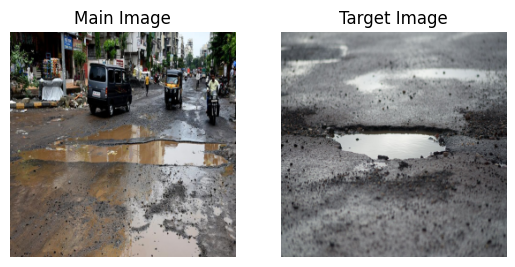

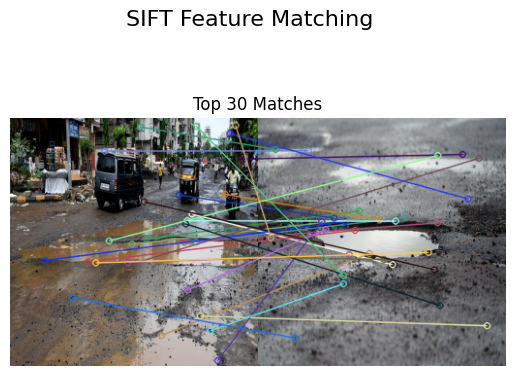

In [6]:
import cv2
import matplotlib.pyplot as plt

image_path = "../Dataset/Sample Images/main.png"
target_path = "../Dataset/Sample Images/target.png"

mainImg = cv2.imread(image_path, 1)
targetImg = cv2.imread(target_path, 1)

# OG Images
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(mainImg, cv2.COLOR_BGR2RGB)), plt.axis("off")
plt.title('Main Image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(targetImg, cv2.COLOR_BGR2RGB)), plt.axis("off")
plt.title('Target Image')

# Image Matching Plot
plt.figure()

# SIFT feature extraction
sift = cv2.SIFT_create()
mainKeypoints, mainDescriptors = sift.detectAndCompute(mainImg, None)
targetKeypoints, targetDescriptors = sift.detectAndCompute(targetImg, None)

# Feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
matches = bf.match(mainDescriptors, targetDescriptors)
matches = sorted(matches, key=lambda x: x.distance)

# Display matched features
matched_img = cv2.drawMatches(mainImg, mainKeypoints, targetImg, targetKeypoints, matches[:30], mainImg, flags=2)

plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB)), plt.axis("off")
plt.title('Top 30 Matches')

# Decorate the plot
plt.suptitle('SIFT Feature Matching', fontsize=16)
plt.show()


We can observe that keypoints arent matched accurately at all since SIFT on its own works well with matching highly similar objects only

So, we try using a different approach where we construct features using SIFT as the starting point

## Descriptor Extraction, PreProcessing and Clustering

#### Extracting Descriptors

In [13]:
import cv2
import pandas as pd
import numpy as np
import os

We now proceed to extract every SIFT Descriptor from the dataset and concatinate them.

In [14]:
def extract_sift_features(image):
    sift = cv2.SIFT_create()
    key_points, descriptors = sift.detectAndCompute(image, None)
    return key_points, descriptors

In [15]:
pothole_processed = [(pothole_dump_path + pothole_path) for pothole_path in os.listdir(pothole_dump_path)]
plain_processed = [(plain_dump_path + plain_path) for plain_path in os.listdir(plain_dump_path)]

# Extract SIFT Features for ALL IMAGES IN DATASET and concatinate them in a dataframe

def extract_descriptor_data() -> pd.DataFrame:
    data = []

    for i in plain_processed:
        img_arr = cv2.imread(i, 0)
        keypoints, descriptor = extract_sift_features(img_arr)
        for i in descriptor:
            descriptorData = {"Vector": i}
            data.append(descriptorData)

    for i in pothole_processed:
        img_arr = cv2.imread(i, 0)
        keypoints, descriptor = extract_sift_features(img_arr)
        for i in descriptor:
            descriptorData = {"Vector": i}
            data.append(descriptorData)
    
    df = pd.DataFrame(data)
    return df

In [13]:
descriptor_df = extract_descriptor_data()
np.save("original_descriptors", descriptor_df["Vector"])

In [14]:
descriptor_df

,Vector
0,"[6.0, 2.0, 1.0, 1.0, 40.0, 118.0, 5.0, 5.0, 90..."
1,"[0.0, 12.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,"[42.0, 47.0, 39.0, 0.0, 0.0, 7.0, 23.0, 11.0, ..."
3,"[2.0, 2.0, 5.0, 18.0, 34.0, 121.0, 86.0, 7.0, ..."
4,"[91.0, 49.0, 10.0, 2.0, 5.0, 4.0, 2.0, 28.0, 4..."
...,...
353556,"[8.0, 76.0, 52.0, 10.0, 16.0, 34.0, 6.0, 2.0, ..."
353557,"[13.0, 17.0, 10.0, 9.0, 37.0, 9.0, 14.0, 29.0,..."
353558,"[15.0, 23.0, 3.0, 0.0, 1.0, 1.0, 3.0, 4.0, 17...."
353559,"[29.0, 60.0, 33.0, 39.0, 113.0, 113.0, 49.0, 1..."


#### PCA On Descriptors (Preprocessing)

Since Dimension of the extracted data is 3.5Lakh x 128, we can try reducing dimensions while aiming to retain 95% of variance to decrease computation time.

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

<i>How Best n_components is selected for PCA - https://www.youtube.com/watch?v=xvfJXNGCQBM

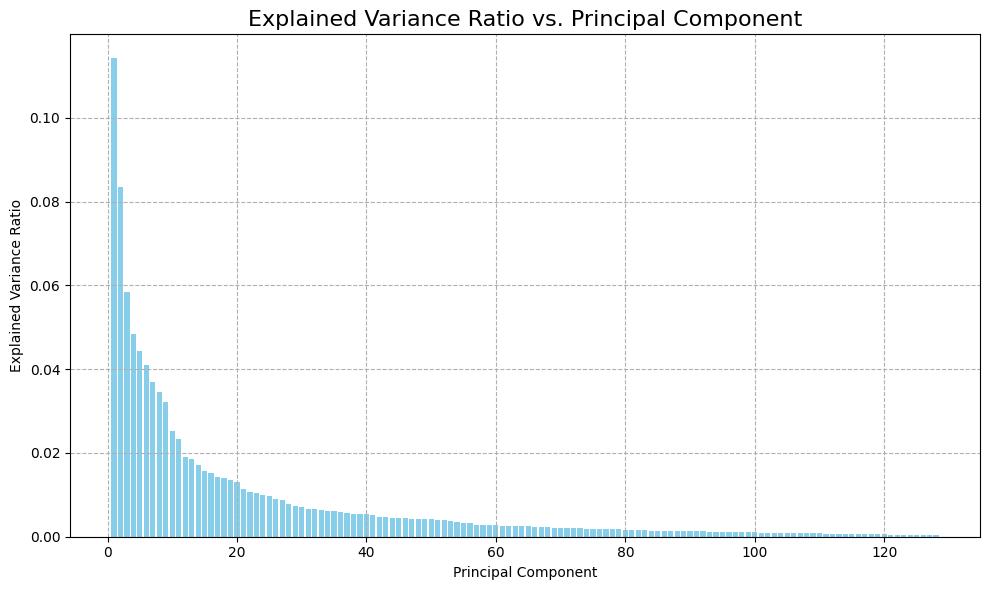

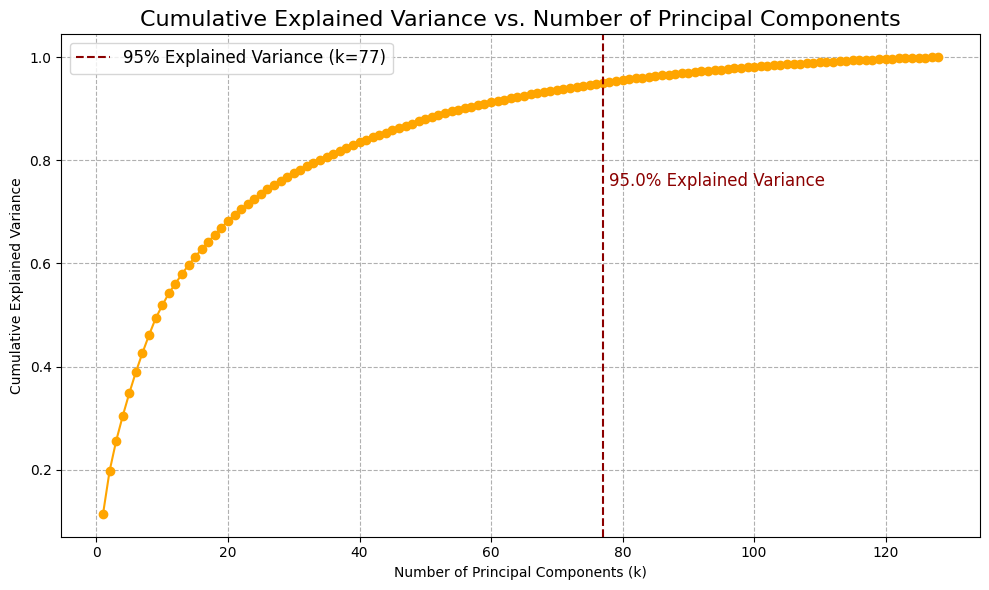

Optimal value of k: 77


In [16]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pca = PCA()
pca.fit(np.vstack(descriptor_df["Vector"]))

# Desired Explained Variance
desired_explained_variance = 0.95

# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Find the smallest k that achieves the desired explained variance
optimal_k = np.argmax(cumulative_explained_variance >= desired_explained_variance) + 1

# Plot the explained variance ratio for each principal component
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Principal Component', fontsize=16)
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()

# Plot the cumulative explained variance with a vertical line at 95%
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', color='orange')
plt.axvline(x=optimal_k, color='darkred', linestyle='--', label=f'95% Explained Variance (k={optimal_k})')

# Add text label next to the line
plt.text(optimal_k + 1, desired_explained_variance - 0.2, f'{desired_explained_variance*100:.1f}% Explained Variance', color='darkred', fontsize=12)

plt.xlabel('Number of Principal Components (k)')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Principal Components', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()


print(f"Optimal value of k: {optimal_k}")


From this, we find out that at thec cumulative explaned variance till the 77th principle component retains about 95% of the data. So we decompose the size of the descriptor matrix to 1x77 and save the PCA decomposer model for later use

In [18]:
from sklearn.decomposition import PCA
import joblib

# Create a PCA instance with the optimal number of components (k)
# pca = PCA(n_components=77)  # Replace 'optimal_k' with your chosen value of k
pca = joblib.load('../Models and Data/pca_77.joblib') 

# Fit PCA to your descriptors
pca.fit(np.vstack(descriptor_df["Vector"]))
# joblib.dump(pca, '../Models and Data/pca_77.joblib')
reduced_descriptors = pca.fit_transform(np.vstack(descriptor_df["Vector"]))

In [37]:
pd.DataFrame([list(x) for x in reduced_descriptors]).head()

,0,1,2,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,76
0,-174.049423,135.871048,18.158228,4.411328,-31.193056,-35.834812,-33.716896,-83.861649,99.908203,-43.572803,...,1.802227,13.632668,29.477715,-6.463534,10.132487,27.644629,-34.062794,6.202442,15.061060,-6.446157
1,-77.064339,87.090454,-117.710960,-50.658100,90.388336,-114.226082,-32.355766,154.590790,-12.772367,7.223535,...,-9.813786,-17.144327,-23.239584,14.687164,-28.092422,-27.739563,-10.915751,-24.645935,-17.089491,2.932073
2,74.564613,29.675573,-104.188812,-48.601711,-70.514023,-80.327110,-40.347538,115.184769,-45.621502,8.157148,...,-39.538101,-29.336920,-18.566957,-33.671669,30.909369,-12.579194,11.451101,-2.608827,10.523934,7.240426
3,-67.078011,-43.917751,116.799294,-139.098343,-99.146004,-23.123131,-109.634575,-93.847702,112.397964,60.807297,...,-26.940300,21.050646,12.506931,4.387887,17.605278,8.109313,17.512732,-8.715095,16.669575,9.905702
4,102.438927,-5.427186,-151.108215,15.765091,-117.069550,-209.681061,2.596571,52.808846,-18.559820,-41.300423,...,25.910635,-9.633666,-10.192071,-30.108683,48.060463,-9.465962,19.671001,-9.521985,-4.675861,-13.233348


In [ ]:
np.save("reduced_descriptors", reduced_descriptors)

#### KMeans Clustering on Descriptors

Once we have obtained the reduced descriptor set, we need be able to group descriptors together such that we can find out the occurences of descriptor classes across images. Later, we can use this histogram of descriptors as features and further preprocess it

First we need to find the optimal value of n_clusters such that we can minimize the Inertia or within cluster sum of squared distances (WCSS) and also minimize the number of clusters at the same time using the "Elbow Method"

In [13]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import json
import pickle

KMeans model training from KMeans N_Cluster 5 to 715

In [ ]:
inertias = {}
K = range(5, 715, 10)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(reduced_descriptors)
    pickle.dump(kmeanModel, open(f"../Models and Data/KMeans_Cluster_SIFT_Saved_PCA/kmeans_{k}.pickle", "wb"))

    inertias[k] = kmeanModel.inertia_

    if(k%15 == 0):
        print(k)

with open("cluster_performance_results.json", "w") as f:
    cluster_data = {"inertias": inertias}
    json.dump(cluster_data, f, indent = 4)

Finding Inertias of KMeans Models

In [14]:
inertias = {}
K = range(5, 715, 10)
for k in K:
    # Building and fitting the model
    kmeanModel = pickle.load(open(f"../Models and Data/KMeans_Cluster_SIFT_Saved_PCA/kmeans_{k}.pickle", 'rb'))
    inertias[k] = kmeanModel.inertia_

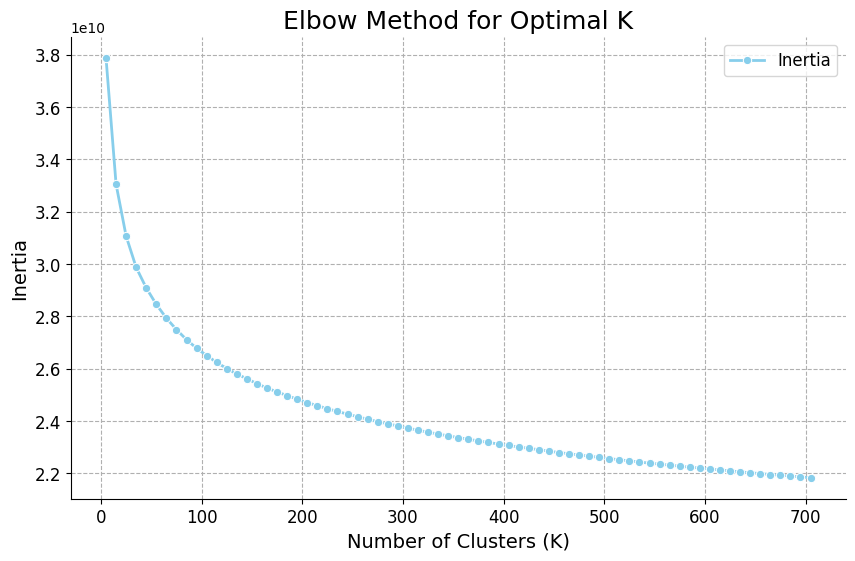

In [17]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(inertias.keys()), y=list(inertias.values()), marker='o', linewidth=2, color='skyblue', label='Inertia')
plt.title('Elbow Method for Optimal K', fontsize=18)
plt.xlabel('Number of Clusters (K)', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--')
plt.legend(fontsize=12)

sns.despine()

Here we notice that there isnt a clear Inflection point. So to find the best value of n_clusters, we need to train models with features extracted using all values of n_clusters

## Generate Descriptor Histograms and TFIDF reweighted Histograms using KMeans cluster models

In [2]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import joblib

import cv2
import pandas as pd
import numpy as np

In [3]:
def extract_sift_features(image):
    sift = cv2.SIFT_create()
    key_points, descriptors = sift.detectAndCompute(image, None)
    return key_points, descriptors

$$
\text{tf-idf}_{t, d} = \text{tf}_{t, d} \times \text{idf}_t = \text{tf}_{t, d} \times \log\left(\frac{N}{df_t}\right)
$$

$$
\text{tf}_{t, d} = \text{number of times visual word t occurs in the image d}
$$

$$
\text{N} = \text{total number of images}
$$

$$
\text{df}_t = \text{number of images containing the visual word t}
$$

$$
\log\left(\frac{N}{\text{df}_t}\right) = \text{measure of how common the visual word t is across all images. Low if visual word d occurs many times, else high}
$$

Now that we have all the trained KMeans models, we start clustering descriptors form each image, and form histograms of descriptors for each image using count vectorization

Once we extract Count Vectors, we can reweight each class label to give them different importance based on their occurences. This can be done using TFIDF Transformation.

In the above latex expressions, we notice that tf (t,d) is the count vectors that we have already calculated.

df(t) is the occurence of that descriptor across all images. As the occurence value increases, N (number of images) / df(t) value decreases, but stays above 1. 

This decreases the value of the Log Term and inturn when multiplied with tf(t,d) which is the count vector, decreases the importance of that class label

In [10]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import joblib

def generateDescriptorHistograms(paths: list, KMeansModel: KMeans, saveTFIDF = False) -> pd.DataFrame:
    pca = joblib.load('../Models and Data/pca_77.joblib') 
    descriptor_list = []
    class_list = []
    image_class = []

    # create array of image descriptors (not flattened)
    for i in range(len(paths)):
        for image_path in paths[i]:
            print(i)
            # print(image_path)

            # read image array grayscale color space
            img_arr = cv2.imread(image_path, 0)

            # extract descriptors from image
            keypoints, descriptor = extract_sift_features(img_arr)

            # skip image because pca cannot be done
            if(descriptor.shape[0]) < 77:
                continue

            # add image descriptors
            descriptor_list.append(descriptor)

            # add image class
            if(i == 0):
                image_class.append("Pothole")
            else:
                image_class.append("Plain")
    
    for i in descriptor_list:
        print(i)
        reduced_descriptors = pca.fit_transform(i)
        class_labels = KMeansModel.predict(reduced_descriptors)
        class_list.append(class_labels)
    
    count_vectorizer = CountVectorizer(tokenizer=lambda x: x.split())
    tfidf_transformer = TfidfTransformer()

    desc_classes = [" ".join(str(x) for x in i) for i in class_list]
    count_matrix = count_vectorizer.fit_transform(desc_classes)
    tfidf_matrix = tfidf_transformer.fit_transform(count_matrix)

    tfidf_model = None
    if(saveTFIDF):
        tfidf_model = tfidf_transformer.fit(count_matrix)
        # pickle.dump(tfidf_model, open("./tfidf_445.pickle", "wb"))

    return count_matrix, tfidf_matrix, image_class, tfidf_model

Here is an illustration that showcases the above

In [150]:
model = pickle.load(open("../Models and Data/KMeans_Cluster_SIFT_Saved_PCA/kmeans_565.pickle", "rb"))
count_matrix, tfidf_matrix, image_class, tfidf_model = generateDescriptorHistograms(paths=[["../Dataset/Resized_Images_256/Pothole/124.022112-pothole-180.png"], []], KMeansModel=model)

289
(1,)


In [155]:
count_matrix.shape

(1, 196)

In [154]:
tfidf_matrix.toarray().shape

(1, 196)

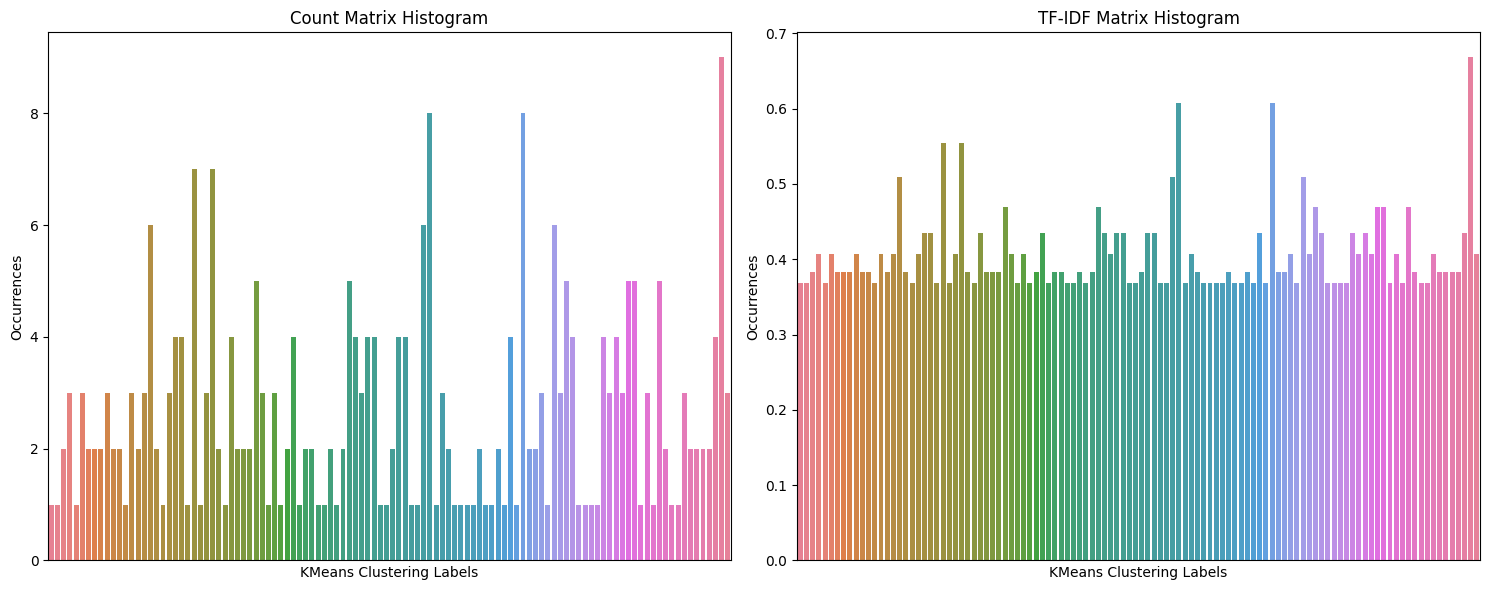

In [46]:
from math import e, pi


count_df = pd.DataFrame(count_matrix.toarray(), columns=[f'Label_{i}' for i in range(count_matrix.shape[1])])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=[f'Label_{i}' for i in range(tfidf_matrix.shape[1])])

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.barplot(data=count_df)
plt.title('Count Matrix Histogram')
plt.xticks([])
plt.xlabel('KMeans Clustering Labels')
plt.ylabel('Occurrences')

plt.subplot(1, 2, 2)
sns.barplot(data= tfidf_df)
plt.title('TF-IDF Matrix Histogram')
plt.xticks([])
plt.xlabel('KMeans Clustering Labels')
plt.ylabel('Occurrences')

plt.tight_layout()
plt.show()

We will now proceed to use these two features independently to asses model performances using KNN and SVM

## ML Models for extracted features

here we declare functions for training models using the above extracted features

We will be using KNN and SVM. Automatic tuning of best hyperparameters is done automatically using gridsearch cv.

Number of hyperparameters that are passed are lesser in quantity to achieve faster training time at the cost of potentially better hyperparameters that yields better accuracies

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

#### KNN

In [105]:
def KNN_best_params(X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray):
    # Create KNN classifier
    knn = KNeighborsClassifier()

    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'n_neighbors': list(range(1, 75)),  # Adjust based on your preference
        # 'weights': ['uniform', 'distance'],  # Weighting scheme for neighbors
        # 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm to compute nearest neighbors
        # 'p': [1, 2],  # Power parameter for the Minkowski metric (1 for Manhattan distance, 2 for Euclidean distance)
    }

    # Use GridSearchCV for hyperparameter tuning
    grid_search_knn = GridSearchCV(knn, param_grid, cv=5, scoring="accuracy", verbose=10)  # 5-fold cross-validation
    grid_search_knn.fit(X_train, y_train)

    y_pred_train = grid_search_knn.predict(X_train)
    y_pred_test = grid_search_knn.predict(X_test)

    best_model_config = grid_search_knn.best_params_
    max_train_score = accuracy_score(y_train, y_pred_train)
    max_test_score = accuracy_score(y_test, y_pred_test)

    return [max_train_score, max_test_score, best_model_config]

#### SVM

In [106]:
def SVM_best_params(X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray):

    svm = SVC()
    param_grid = {
        'C': [0.01, 0.1, 1.0, 10.0],  # Regularization parameter
        'kernel': ['linear', 'rbf'],  # Kernel type
        # 'C': [0.1, 1, 10, 100],  # Regularization parameter
        # 'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Choice of kernel
        # 'gamma': [0.01, 0.1, 1, 10],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
        # 'degree': [2, 3, 4],  # Degree of the polynomial kernel (only for 'poly')
        # 'coef0': [0.0, 1.0, 2.0],  # Independent term in the kernel function (only for 'poly' and 'sigmoid')
    }

    grid_search_svm = GridSearchCV(svm, param_grid, cv=5, scoring="accuracy", verbose=10)  # 2-fold cross-validation
    grid_search_svm.fit(X_train, y_train)

    y_pred_train = grid_search_svm.predict(X_train)
    y_pred_test = grid_search_svm.predict(X_test)

    best_model_config = grid_search_svm.best_params_
    max_train_score = accuracy_score(y_train, y_pred_train)
    max_test_score = accuracy_score(y_test, y_pred_test)

    return [max_train_score, max_test_score, best_model_config]

## Manual ML Model Training to prevent overfitting

In [13]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy import sparse

In [14]:
def SVM_train(X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray, params, cv):

    # param_grid = {
    #     'C': [0.01, 0.1, 1.0, 10.0],  # Regularization parameter
    #     'kernel': ['linear', 'rbf'],  # Kernel type
    #     # 'C': [0.1, 1, 10, 100],  # Regularization parameter
    #     # 'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Choice of kernel
    #     # 'gamma': [0.01, 0.1, 1, 10],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    #     # 'degree': [2, 3, 4],  # Degree of the polynomial kernel (only for 'poly')
    #     # 'coef0': [0.0, 1.0, 2.0],  # Independent term in the kernel function (only for 'poly' and 'sigmoid')
    # }


    # grid_search_svm = GridSearchCV(svm, param_grid, cv=5, scoring="accuracy", verbose=10)  # 2-fold cross-validation
    svm = SVC()
    grid_search_svm = GridSearchCV(svm, params, cv=cv, scoring="accuracy", verbose=10)  # 2-fold cross-validation
    grid_search_svm.fit(X_train, y_train)

    y_pred_train = grid_search_svm.predict(X_train)
    y_pred_test = grid_search_svm.predict(X_test)

    max_train_score = accuracy_score(y_train, y_pred_train)
    max_test_score = accuracy_score(y_test, y_pred_test)
    test_train_ratio = (max_test_score / max_train_score)

    return {"max_train_score":max_train_score,
            "max_test_score":max_test_score,
            "test_train_ratio":test_train_ratio}

In [117]:
# training for tfidf_565
clusterSize = 445
# param_grid = {
    #     'C': [0.01, 0.1, 1.0, 10.0],  # Regularization parameter
    #     'kernel': ['linear', 'rbf'],  # Kernel type
    #     # 'C': [0.1, 1, 10, 100],  # Regularization parameter
    #     # 'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Choice of kernel
    #     # 'gamma': [0.01, 0.1, 1, 10],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    #     # 'degree': [2, 3, 4],  # Degree of the polynomial kernel (only for 'poly')
    #     # 'coef0': [0.0, 1.0, 2.0],  # Independent term in the kernel function (only for 'poly' and 'sigmoid')
    # }
params = {
        "C": [0.5],
        "kernel": ["rbf"],
        # 'gamma': [10],
}
cv = 2

groundtruth = np.load("../Models and Data/K_Cluster_Extracted_Features_New/Image_Classes.npy")
data = sparse.load_npz(f"../Models and Data/K_Cluster_Extracted_Features_New/Extracted_{clusterSize}/Count_vectors_{clusterSize}.npz")
print(data.shape, groundtruth.shape)
X_train, X_test, y_train, y_test = train_test_split(data, groundtruth, test_size=0.5, random_state=42)
res = SVM_train(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, params=params, cv=cv)

print(res)

(712, 445) (712,)
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2; 1/1] START C=0.5, kernel=rbf...........................................
[CV 1/2; 1/1] END ............C=0.5, kernel=rbf;, score=0.640 total time=   0.0s
[CV 2/2; 1/1] START C=0.5, kernel=rbf...........................................
[CV 2/2; 1/1] END ............C=0.5, kernel=rbf;, score=0.742 total time=   0.0s
{'max_train_score': 0.8258426966292135, 'max_test_score': 0.6797752808988764, 'test_train_ratio': 0.8231292517006803}


## Training and Testing on Count Vector and TF-IDF features for all K-Means Cluster sizes

In [107]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

import numpy as np
import os
import json
import pickle

In the following function, we will perform extraction of descriptors, reduction, construction of CountVector and TFIDF Matrices for each image and training of this data using KNN and SVM models for ALL the trained KMeans models.
The results will be stored and later used for performance visualizations

In [40]:
def calculatePerformanceData():
    # paths for kmeans model retieval
    model_paths = [(f"../Models and Data/KMeans_Cluster_SIFT_Saved_PCA/kmeans_{i}.pickle") for i in list(range(5, 715, 10))]

    # storage class that will contain ALL performance data that will be dumped in the end
    sift_classifier_performance_outputs = []


    # for all generated kmeans cluster models
    for path in model_paths:
        
        # Initialization ============================================================================================================
        
        performance_model = {
            "cluster_size":0,
            "KNN_Acc_Count":{"Accuracy_train":0, "Accuracy_test":0, "Config":{}},
            "SVM_Acc_Count":{"Accuracy_train":0, "Accuracy_test":0, "Config":{}},
            "KNN_Acc_TFIDF":{"Accuracy_train":0, "Accuracy_test":0, "Config":{}},
            "SVM_Acc_TFIDF":{"Accuracy_train":0, "Accuracy_test":0, "Config":{}},
        }
        
        # calculate and store cluster size
        cluster_size = int(path.split(".")[-2].split("_")[-1])
        print(f"\n\n\n!--- Current Cluster Size is {cluster_size} ---!")
        performance_model["cluster_size"] = cluster_size

        
        
        # Pre - Processing Histogram ============================================================================================================
        
        # load model and Label SIFT Descriptor Classes
        model = pickle.load(open(path, "rb"))

        # load image paths for generating descriptor histograms
        pothole_processed = [(pothole_dump_path + pothole_path) for pothole_path in os.listdir(pothole_dump_path)]
        plain_processed = [(plain_dump_path + plain_path) for plain_path in os.listdir(plain_dump_path)]

        # Generate Histogram Dataframe with labels (pothole or plain)
        print("!--- Starting Computation of Count and TFIDF Matrix for image descriptors ---!")
        count_matrix, tfidf_matrix, image_class = generateDescriptorHistograms(paths=[pothole_processed, plain_processed], KMeansModel=model)
        print("!--- Finished Computation of Count and TFIDF Matrix for image descriptors ---!")

        
        
        # Training Histogram Data ============================================================================================================
        
        # split dataset into train test without TFIDF Transformation
        X_train, X_test, y_train, y_test = train_test_split(count_matrix, image_class, test_size=0.2, random_state=42)

        # KNN Classifier Training ------------------------------------------------------------------------------------------------
        print("!--- Starting KNN Classification for Count Data ---!")
        max_train_score, max_test_score, best_model_config = KNN_best_params(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

        # store values
        performance_model["KNN_Acc_Hist"] = {"Accuracy_train":max_train_score, "Accuracy_test":max_test_score, "Config":best_model_config}

        ############################ --------------------------- ############################ --------------------------- ############################

        # SVM Classifier Training ------------------------------------------------------------------------------------------------
        print("!--- Starting SVM Classification for Count Data ---!")
        max_train_score, max_test_score, best_model_config = SVM_best_params(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

        # store values
        performance_model["SVM_Acc_Hist"] = {"Accuracy_train":max_train_score, "Accuracy_test":max_test_score, "Config":best_model_config}





        # Training TFIDF Processed Data ============================================================================================================
        
        # split dataset and train with TFIDF Vectorization
        X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, image_class, test_size=0.2, random_state=42)

        # KNN Classifier Training ------------------------------------------------------------------------------------------------
        print("!--- Starting KNN Classification for TFIDF Data ---!")
        max_train_score, max_test_score, best_model_config = KNN_best_params(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

        # store values
        performance_model["KNN_Acc_TFIDF"] = {"Accuracy_train":max_train_score, "Accuracy_test":max_test_score, "Config":best_model_config}

        ############################ --------------------------- ############################ --------------------------- ############################

        # SVM Classifier Training ------------------------------------------------------------------------------------------------
        print("!--- Starting SVM Classification for TFIDF Data ---!")
        max_train_score, max_test_score, best_model_config = SVM_best_params(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

        # store values
        performance_model["SVM_Acc_TFIDF"] = {"Accuracy_train":max_train_score, "Accuracy_test":max_test_score, "Config":best_model_config}


        # adding single cluster performance data to storage and also dumping it
        sift_classifier_performance_outputs.append(performance_model)
        with open(f"../Models and Data/PerformanceDump_PostCountVectorizer/performanceData_clusterSize{cluster_size}.json", "w") as f:
            json.dump(performance_model, f, indent = 4)
        
    # dumping ALL performance data
    with open(f"../Models and Data/PerformanceDump_PostCountVectorizer/performanceData.json", "w") as f:
        json.dump(cluster_data, f, indent = 4)

In [ ]:
calculatePerformanceData()

## Visualizing Performances

In [108]:
import json
import matplotlib.pyplot as plt

In [2]:
performance_dump_paths = [f"../Models and Data/PerformanceDump_PostCountVectorizer/performanceData_clusterSize{i}.json" for i in range(5, 715, 10)]
performance_data = []
for i in performance_dump_paths:
    with open(i) as f:
        performance_data.append(json.loads(f.read()))

In [3]:
performance_cluster_size = []

KNN_Hist_Acc_Train = []
KNN_Hist_Acc_Test = []
SVM_Hist_Acc_Train = []
SVM_Hist_Acc_Test = []

KNN_TFIDF_Acc_Train = []
KNN_TFIDF_Acc_Test = []
SVM_TFIDF_Acc_Train = []
SVM_TFIDF_Acc_Test = []

for i in performance_data:
    performance_cluster_size.append(i["cluster_size"])
    
    KNN_Hist_Acc_Train.append(i["KNN_Acc_Hist"]["Accuracy_train"])
    KNN_Hist_Acc_Test.append(i["KNN_Acc_Hist"]["Accuracy_test"])

    SVM_Hist_Acc_Train.append(i["SVM_Acc_Hist"]["Accuracy_train"])
    SVM_Hist_Acc_Test.append(i["SVM_Acc_Hist"]["Accuracy_test"])

    KNN_TFIDF_Acc_Train.append(i["KNN_Acc_TFIDF"]["Accuracy_train"])
    KNN_TFIDF_Acc_Test.append(i["KNN_Acc_TFIDF"]["Accuracy_test"])

    SVM_TFIDF_Acc_Train.append(i["SVM_Acc_TFIDF"]["Accuracy_train"])
    SVM_TFIDF_Acc_Test.append(i["SVM_Acc_TFIDF"]["Accuracy_test"])

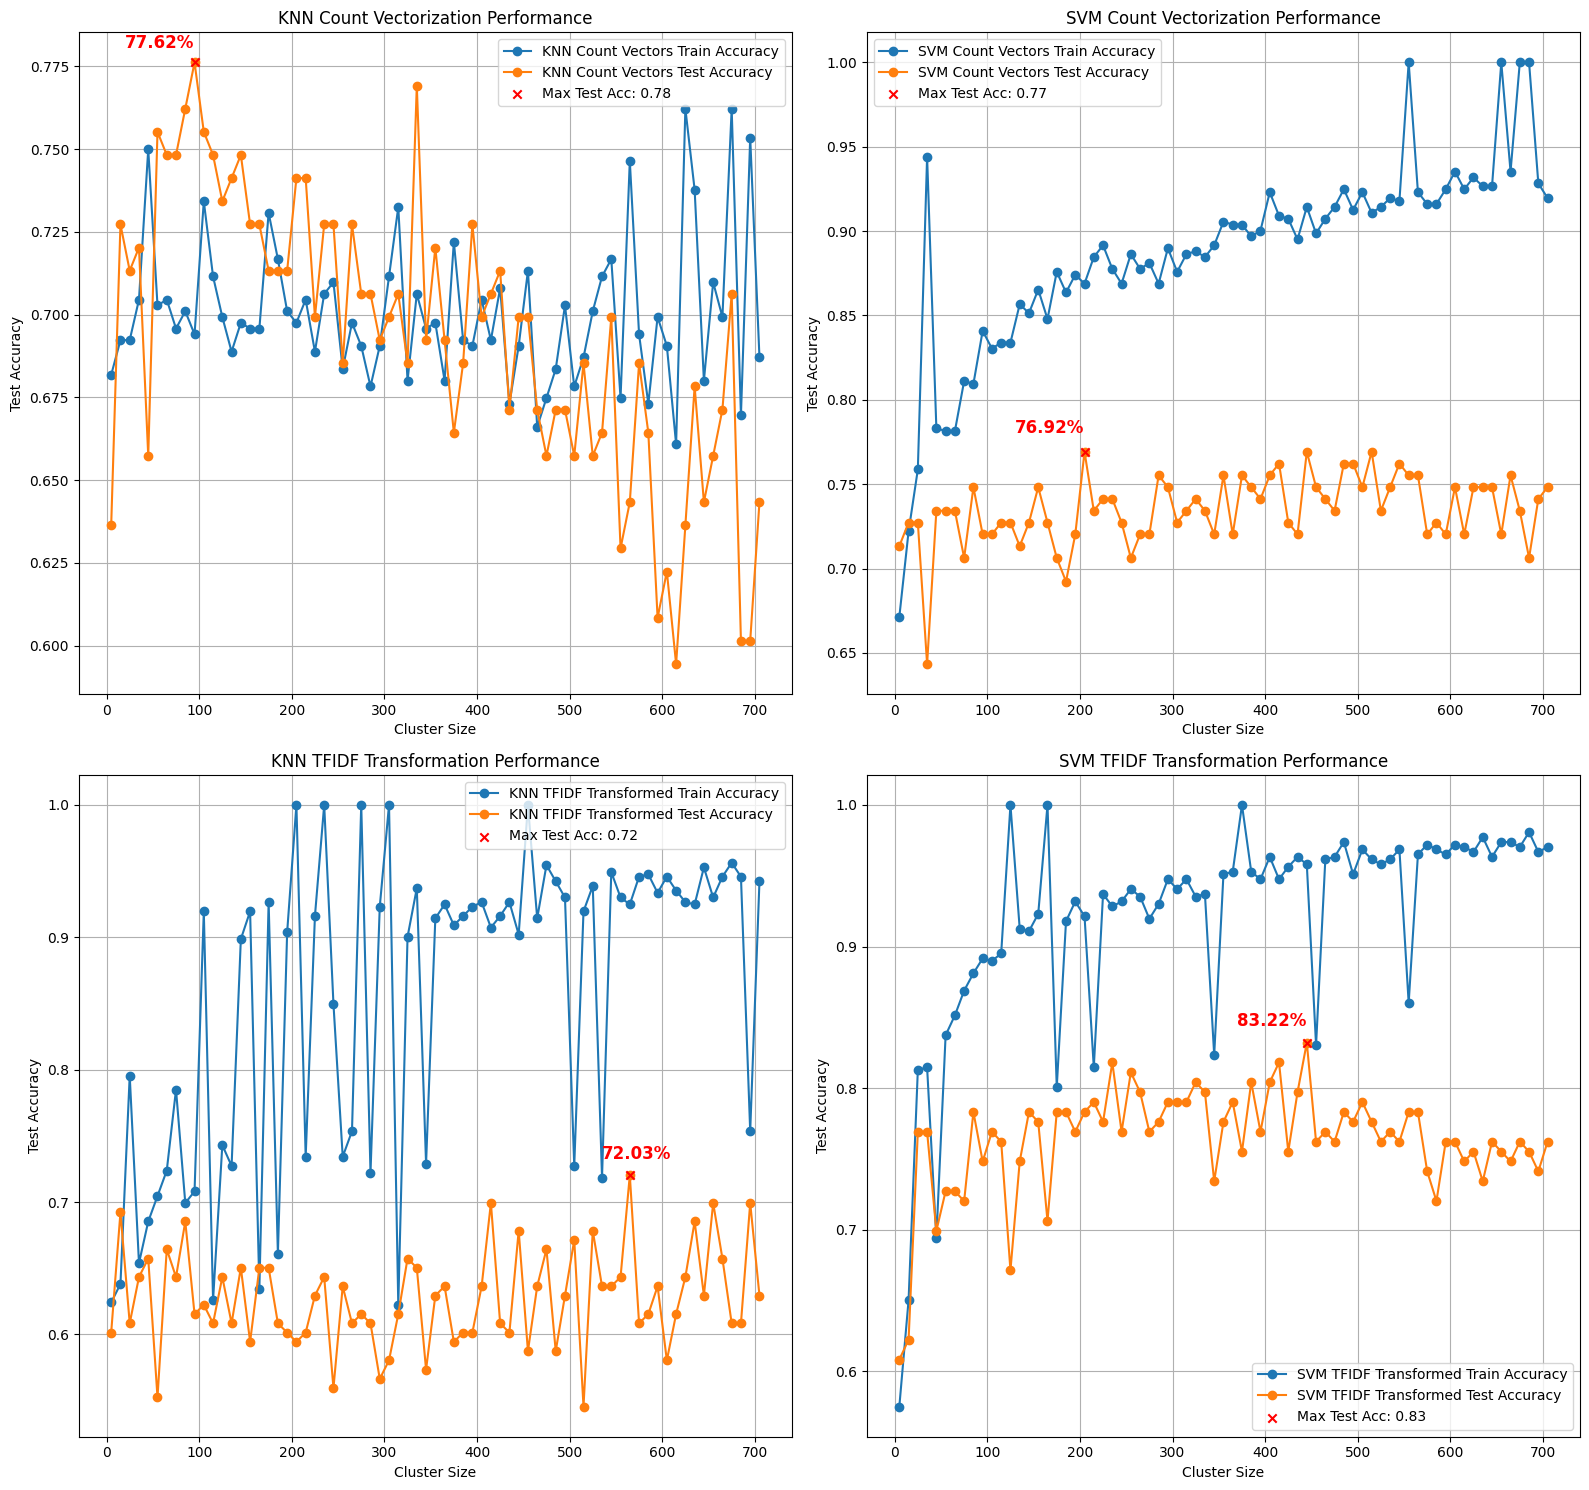

In [5]:
plt.figure(figsize=(16, 15))

# KNN Count Vectorization
plt.subplot(2, 2, 1)
max_test_accuracy_knn_hist = max(KNN_Hist_Acc_Test)
plt.plot(performance_cluster_size, KNN_Hist_Acc_Train, label="KNN Count Vectors Train Accuracy", marker='o')
plt.plot(performance_cluster_size, KNN_Hist_Acc_Test, label="KNN Count Vectors Test Accuracy", marker='o')
plt.scatter(performance_cluster_size[KNN_Hist_Acc_Test.index(max_test_accuracy_knn_hist)], max_test_accuracy_knn_hist, color='red', label=f'Max Test Acc: {max_test_accuracy_knn_hist:.2f}', marker='x', zorder=5)
plt.text(performance_cluster_size[KNN_Hist_Acc_Test.index(max_test_accuracy_knn_hist)], max_test_accuracy_knn_hist + 0.003, f'{max_test_accuracy_knn_hist*100:.2f}%', fontsize = 12, color='red', ha='right', va='bottom', weight='bold')
plt.xlabel("Cluster Size")
plt.ylabel("Test Accuracy")
plt.title("KNN Count Vectorization Performance")
plt.legend()
plt.grid(True)

# SVM Count Vectorization
plt.subplot(2, 2, 2)
max_test_accuracy_svm_hist = max(SVM_Hist_Acc_Test)
plt.plot(performance_cluster_size, SVM_Hist_Acc_Train, label="SVM Count Vectors Train Accuracy", marker='o')
plt.plot(performance_cluster_size, SVM_Hist_Acc_Test, label="SVM Count Vectors Test Accuracy", marker='o')
plt.scatter(performance_cluster_size[SVM_Hist_Acc_Test.index(max_test_accuracy_svm_hist)], max_test_accuracy_svm_hist, color='red', label=f'Max Test Acc: {max_test_accuracy_svm_hist:.2f}', marker='x', zorder=5)
plt.text(performance_cluster_size[SVM_Hist_Acc_Test.index(max_test_accuracy_svm_hist)], max_test_accuracy_svm_hist + 0.009, f'{max_test_accuracy_svm_hist*100:.2f}%', fontsize = 12, color='red', ha='right', va='bottom', weight='bold')
plt.xlabel("Cluster Size")
plt.ylabel("Test Accuracy")
plt.title("SVM Count Vectorization Performance")
plt.legend()
plt.grid(True)

# KNN TFIDF Transformation
plt.subplot(2, 2, 3)
max_test_accuracy_knn_tfidf = max(KNN_TFIDF_Acc_Test)
plt.plot(performance_cluster_size, KNN_TFIDF_Acc_Train, label="KNN TFIDF Transformed Train Accuracy", marker='o')
plt.plot(performance_cluster_size, KNN_TFIDF_Acc_Test, label="KNN TFIDF Transformed Test Accuracy", marker='o')
plt.scatter(performance_cluster_size[KNN_TFIDF_Acc_Test.index(max_test_accuracy_knn_tfidf)], max_test_accuracy_knn_tfidf, color='red', label=f'Max Test Acc: {max_test_accuracy_knn_tfidf:.2f}', marker='x', zorder=5)
plt.text(performance_cluster_size[KNN_TFIDF_Acc_Test.index(max_test_accuracy_knn_tfidf)] + 45, max_test_accuracy_knn_tfidf + 0.009, f'{max_test_accuracy_knn_tfidf*100:.2f}%', fontsize = 12, color='red', ha='right', va='bottom', weight='bold')
plt.xlabel("Cluster Size")
plt.ylabel("Test Accuracy")
plt.title("KNN TFIDF Transformation Performance")
plt.legend()
plt.grid(True)

# SVM TFIDF Transformation
plt.subplot(2, 2, 4)
max_test_accuracy_svm_tfidf = max(SVM_TFIDF_Acc_Test)
plt.plot(performance_cluster_size, SVM_TFIDF_Acc_Train, label="SVM TFIDF Transformed Train Accuracy", marker='o')
plt.plot(performance_cluster_size, SVM_TFIDF_Acc_Test, label="SVM TFIDF Transformed Test Accuracy", marker='o')
plt.scatter(performance_cluster_size[SVM_TFIDF_Acc_Test.index(max_test_accuracy_svm_tfidf)], max_test_accuracy_svm_tfidf, color='red', label=f'Max Test Acc: {max_test_accuracy_svm_tfidf:.2f}', marker='x', zorder=5)
plt.text(performance_cluster_size[SVM_TFIDF_Acc_Test.index(max_test_accuracy_svm_tfidf)], max_test_accuracy_svm_tfidf + 0.009, f'{max_test_accuracy_svm_tfidf*100:.2f}%', fontsize = 12, color='red', ha='right', va='bottom', weight='bold')
plt.xlabel("Cluster Size")
plt.ylabel("Test Accuracy")
plt.title("SVM TFIDF Transformation Performance")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("results.png")
plt.show()

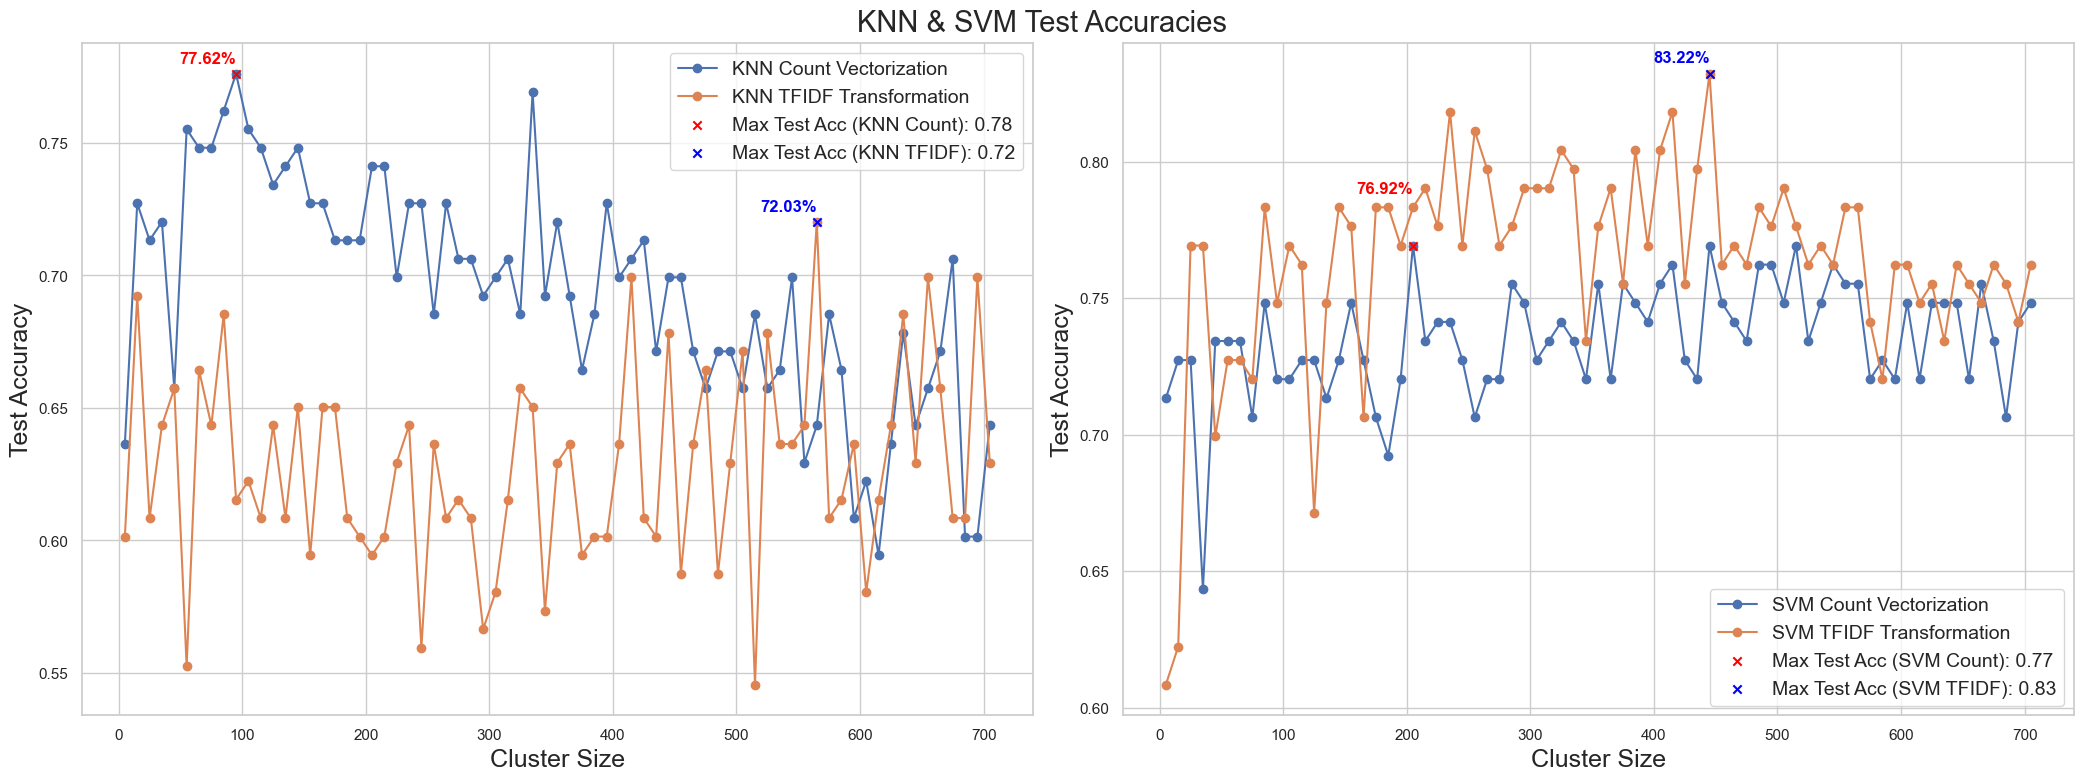

In [209]:
plt.figure(figsize=(21, 15))
plt.suptitle("KNN & SVM Test Accuracies", fontsize=21)

plt.subplot(2, 2, 1)
plt.plot(performance_cluster_size, KNN_Hist_Acc_Test, label="KNN Count Vectorization", marker='o')
plt.plot(performance_cluster_size, KNN_TFIDF_Acc_Test, label="KNN TFIDF Transformation", marker='o')
max_test_accuracy_knn_count = max(KNN_Hist_Acc_Test)
plt.scatter(performance_cluster_size[KNN_Hist_Acc_Test.index(max_test_accuracy_knn_count)], max_test_accuracy_knn_count, color='red', label=f'Max Test Acc (KNN Count): {max_test_accuracy_knn_count:.2f}', marker='x', zorder=5)
plt.text(performance_cluster_size[KNN_Hist_Acc_Test.index(max_test_accuracy_knn_count)], max_test_accuracy_knn_count + 0.003, f'{max_test_accuracy_knn_count*100:.2f}%', color='red', ha='right', va='bottom', weight='bold', fontsize=12)
max_test_accuracy_knn_tfidf = max(KNN_TFIDF_Acc_Test)
plt.scatter(performance_cluster_size[KNN_TFIDF_Acc_Test.index(max_test_accuracy_knn_tfidf)], max_test_accuracy_knn_tfidf, color='blue', label=f'Max Test Acc (KNN TFIDF): {max_test_accuracy_knn_tfidf:.2f}', marker='x', zorder=5)
plt.text(performance_cluster_size[KNN_TFIDF_Acc_Test.index(max_test_accuracy_knn_tfidf)], max_test_accuracy_knn_tfidf + 0.003, f'{max_test_accuracy_knn_tfidf*100:.2f}%', color='blue', ha='right', va='bottom', weight='bold', fontsize=12)
plt.xlabel("Cluster Size", fontsize=18)
plt.ylabel("Test Accuracy", fontsize=18)
plt.legend(fontsize=14)

plt.subplot(2, 2, 2)
plt.plot(performance_cluster_size, SVM_Hist_Acc_Test, label="SVM Count Vectorization", marker='o')
plt.plot(performance_cluster_size, SVM_TFIDF_Acc_Test, label="SVM TFIDF Transformation", marker='o')
max_test_accuracy_svm_count = max(SVM_Hist_Acc_Test)
plt.scatter(performance_cluster_size[SVM_Hist_Acc_Test.index(max_test_accuracy_svm_count)], max_test_accuracy_svm_count, color='red', label=f'Max Test Acc (SVM Count): {max_test_accuracy_svm_count:.2f}', marker='x', zorder=5)
plt.text(performance_cluster_size[SVM_Hist_Acc_Test.index(max_test_accuracy_svm_count)], max_test_accuracy_svm_count + 0.018, f'{max_test_accuracy_svm_count*100:.2f}%', color='red', ha='right', va='bottom', weight='bold', fontsize=12)
max_test_accuracy_svm_tfidf = max(SVM_TFIDF_Acc_Test)
plt.scatter(performance_cluster_size[SVM_TFIDF_Acc_Test.index(max_test_accuracy_svm_tfidf)], max_test_accuracy_svm_tfidf, color='blue', label=f'Max Test Acc (SVM TFIDF): {max_test_accuracy_svm_tfidf:.2f}', marker='x', zorder=5)
plt.text(performance_cluster_size[SVM_TFIDF_Acc_Test.index(max_test_accuracy_svm_tfidf)], max_test_accuracy_svm_tfidf + 0.003, f'{max_test_accuracy_svm_tfidf*100:.2f}%', color='blue', ha='right', va='bottom', weight='bold', fontsize=12)
plt.xlabel("Cluster Size", fontsize=18)
plt.ylabel("Test Accuracy", fontsize=18)
plt.legend(fontsize=14)

plt.tight_layout()
plt.show()


#### Model Stats

In [6]:
KNN_CV_Max = max(KNN_Hist_Acc_Test)
KNN_CV_Max_cluster = performance_cluster_size[KNN_Hist_Acc_Test.index(KNN_CV_Max)]

SVM_CV_Max = max(SVM_Hist_Acc_Test)
SVM_CV_Max_cluster = performance_cluster_size[SVM_Hist_Acc_Test.index(SVM_CV_Max)]

KNN_TFIDF_Max = max(KNN_TFIDF_Acc_Test)
KNN_TFIDF_Max_cluster = performance_cluster_size[KNN_TFIDF_Acc_Test.index(KNN_TFIDF_Max)]

SVM_TFIDF_Max = max(SVM_TFIDF_Acc_Test)
SVM_TFIDF_Max_cluster = performance_cluster_size[SVM_TFIDF_Acc_Test.index(SVM_TFIDF_Max)]

print("Max Accuracies ===================================\n")
print(f"KNN Count Vectorization Accuracy : {KNN_CV_Max} at KMeans Cluster Size : {KNN_CV_Max_cluster}")
print(f"SVM Count Vectorization Accuracy : {SVM_CV_Max} at KMeans Cluster Size : {SVM_CV_Max_cluster}")
print(f"KNN TFIDF Transformation Accuracy : {KNN_TFIDF_Max} at KMeans Cluster Size : {KNN_TFIDF_Max_cluster}")
print(f"SVM TFIDF Transformation Accuracy : {SVM_TFIDF_Max} at KMeans Cluster Size : {SVM_TFIDF_Max_cluster}")

Max Accuracies ===================================

KNN Count Vectorization Accuracy : 0.7762237762237763 at KMeans Cluster Size : 95
SVM Count Vectorization Accuracy : 0.7692307692307693 at KMeans Cluster Size : 205
KNN TFIDF Transformation Accuracy : 0.7202797202797203 at KMeans Cluster Size : 565
SVM TFIDF Transformation Accuracy : 0.8321678321678322 at KMeans Cluster Size : 445


#### Train and Dump Best Model

In [109]:
import pickle
from sklearn.model_selection import train_test_split
import numpy as np
import joblib
import os

In [110]:
def SVM_best_params(X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray):

    svm = SVC()
    param_grid = {
        "C": [1.0],
        "kernel": ["rbf"]
    }
    grid_search_svm = GridSearchCV(svm, param_grid, cv=5, scoring="accuracy", verbose=10)  # 2-fold cross-validation
    grid_search_svm.fit(X_train, y_train)

    y_pred_train = grid_search_svm.predict(X_train)
    y_pred_test = grid_search_svm.predict(X_test)

    best_model_config = grid_search_svm.best_params_
    estimator = grid_search_svm.best_estimator_
    max_train_score = accuracy_score(y_train, y_pred_train)
    max_test_score = accuracy_score(y_test, y_pred_test)

    return [estimator, max_train_score, max_test_score, best_model_config]

In [111]:
def KNN_best_params(X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray):
    knn = KNeighborsClassifier()
    param_grid = {
        'n_neighbors': list(range(1, 75))
    }
    grid_search_knn = GridSearchCV(knn, param_grid, cv=5, scoring="accuracy", verbose=0)  # 5-fold cross-validation
    grid_search_knn.fit(X_train, y_train)

    y_pred_train = grid_search_knn.predict(X_train)
    y_pred_test = grid_search_knn.predict(X_test)

    best_model_config = grid_search_knn.best_params_
    estimator = grid_search_knn.best_estimator_
    max_train_score = accuracy_score(y_train, y_pred_train)
    max_test_score = accuracy_score(y_test, y_pred_test)

    print(max_train_score, max_test_score)

    return [estimator, max_train_score, max_test_score, best_model_config]

In [133]:
# K_Cluster_Sizes = [95, 205, 445, 565]
K_Cluster_Sizes = [565]
pothole_processed = [(pothole_dump_path + pothole_path) for pothole_path in os.listdir(pothole_dump_path)]
plain_processed = [(plain_dump_path + plain_path) for plain_path in os.listdir(plain_dump_path)]
for i in K_Cluster_Sizes:

    model = pickle.load(open(f"../Models and Data/KMeans_Cluster_SIFT_Saved_PCA/kmeans_{i}.pickle", "rb"))
    print(f"extracting data - {i}")
    count_matrix, tfidf_matrix, image_class, tfidf_model = generateDescriptorHistograms(paths=[pothole_processed, plain_processed],
                                                                                        KMeansModel=model, saveTFIDF=True)
    # break
    
    X_train, X_test, y_train, y_test = train_test_split(count_matrix, image_class, test_size=0.2, random_state=42)
    print(f"training count KNN - {i}")
    model_knn_count, a, b, c = KNN_best_params(X_train, X_test, y_train, y_test)
    print(f"training count SVM - {i}")
    model_svm_count, a, b, c = SVM_best_params(X_train, X_test, y_train, y_test)
    joblib.dump(model_knn_count, f"../Models and Data/KNN_SVM_Models_Best/KNN_Count_{i}.joblib")
    joblib.dump(model_svm_count, f"../Models and Data/KNN_SVM_Models_Best/SVM_Count_{i}.joblib")


    X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, image_class, test_size=0.2, random_state=42)
    print(f"training tfidf KNN - {i}")
    model_knn_tfidf, a, b, c = KNN_best_params(X_train, X_test, y_train, y_test)
    print(f"training tfidf SVM - {i}")
    model_svm_tfidf, a, b, c = SVM_best_params(X_train, X_test, y_train, y_test)
    joblib.dump(model_knn_tfidf, f"../Models and Data/KNN_SVM_Models_Best/KNN_TFIDF_{i}.joblib")
    joblib.dump(model_svm_tfidf, f"../Models and Data/KNN_SVM_Models_Best/SVM_TFIDF_{i}.joblib")
    
    joblib.dump(tfidf_model, f"../Models and Data/KNN_SVM_Models_Best/TFIDF_{i}.joblib")

extracting data - 565
608
(712,)


In [130]:
tfidf_matrix

<712x564 sparse matrix of type '<class 'numpy.float64'>'
	with 177696 stored elements in Compressed Sparse Row format>

## Calculating Performance Metrics of Best Model - SVM TFIDF Transformed Count Vectors

In [61]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, jaccard_score, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.preprocessing import label_binarize

In [48]:
model_path = './SVM_TFIDF_445.joblib'
svm_model = joblib.load(model_path)
y_pred = svm_model.predict(X_test)

In [68]:
pos_label = 'Plain'
y_test_binary = label_binarize(y_test, classes=['Pothole', 'Plain'])
y_pred_binary = label_binarize(y_pred, classes=['Pothole', 'Plain'])

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

jaccard = jaccard_score(y_test_binary, y_pred_binary)
print("Jaccard's Index:", jaccard)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
print("True Positive Rate (TPR):", tpr)
print("False Positive Rate (FPR):", fpr)

roc_auc = roc_auc_score(y_test_binary, y_pred_binary)
print("ROC-AUC:", roc_auc)

Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

       Plain       0.72      0.86      0.79        64
     Pothole       0.87      0.73      0.79        79

    accuracy                           0.79       143
   macro avg       0.79      0.80      0.79       143
weighted avg       0.80      0.79      0.79       143

Jaccard's Index: 0.6470588235294118
Confusion Matrix:
[[55  9]
 [21 58]]
True Positive Rate (TPR): 0.7341772151898734
False Positive Rate (FPR): 0.140625
ROC-AUC: 0.7967761075949367


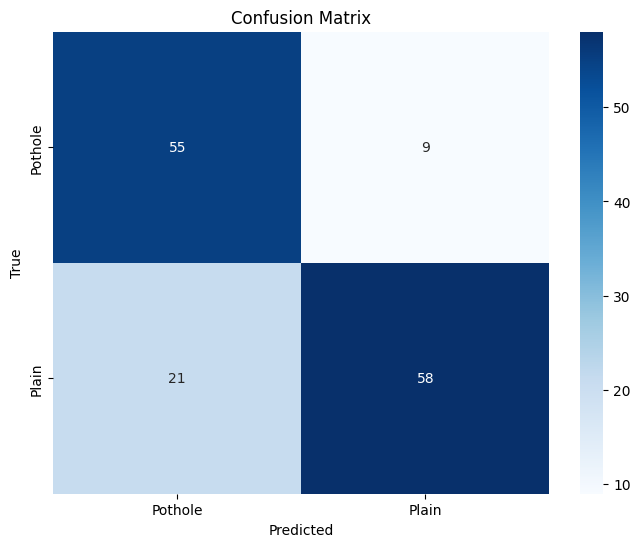

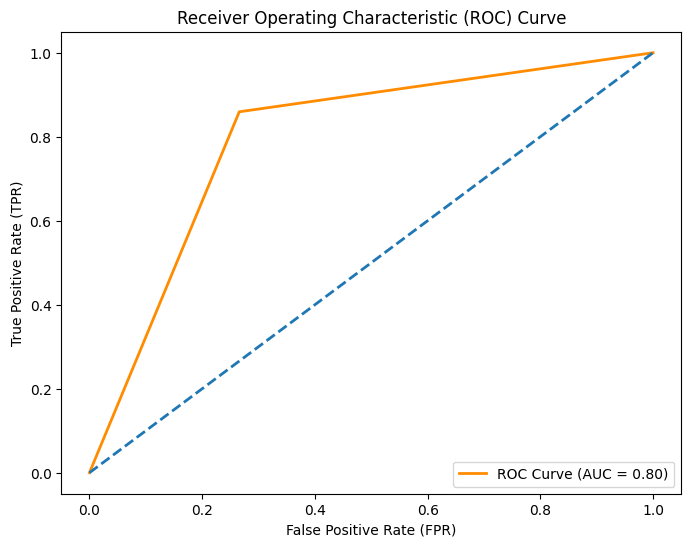

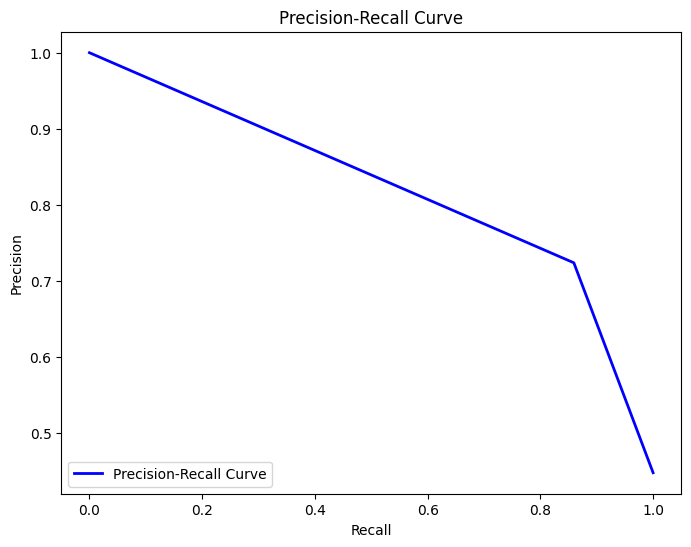

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True,cmap='Blues', xticklabels=['Pothole', 'Plain'], yticklabels=['Pothole', 'Plain'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

fpr, tpr, _ = roc_curve(y_test_binary.ravel(), y_pred_binary.ravel())
roc_auc = auc(fpr, tpr)

# the roc curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

precision, recall, _ = precision_recall_curve(y_test_binary.ravel(), y_pred_binary.ravel())

# PR Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


# Dumping Extracted Count Vector and TFIDF Vector data

In [4]:
import pickle
import numpy as np
import os
from scipy import sparse

In [ ]:
model_paths = [(f"../Models and Data/KMeans_Cluster_SIFT_Saved_PCA/kmeans_{i}.pickle") for i in list(range(5, 715, 10))]
for path in model_paths:
    kmeans_cluster_count = path.split("_")[-1].split(".")[0]
    print(kmeans_cluster_count)


    model = pickle.load(open(path, "rb"))
    pothole_processed = [(pothole_dump_path + pothole_path) for pothole_path in os.listdir(pothole_dump_path)]
    plain_processed = [(plain_dump_path + plain_path) for plain_path in os.listdir(plain_dump_path)]
    count_matrix, tfidf_matrix, image_class, tfidf_model = generateDescriptorHistograms(paths=[pothole_processed, plain_processed], KMeansModel=model)

    dump_path = f"../Models and Data/K_Cluster_Extracted_Features/Extracted_{kmeans_cluster_count}"
    os.mkdir(dump_path)
    np.save(f"{dump_path}/count_vectors_{kmeans_cluster_count}", count_matrix)
    np.save(f"{dump_path}/tfidf_vectors_{kmeans_cluster_count}", tfidf_matrix)
    np.save(f"../Models and Data/K_Cluster_Extracted_Features/Image_Classes", image_class)

In [ ]:
model_paths = [(f"../Models and Data/KMeans_Cluster_SIFT_Saved_PCA/kmeans_{i}.pickle") for i in [95, 205, 445, 565]]

plainPath = "../Dataset/Resized_Images_256/Plain/"
potholePath = "../Dataset/Resized_Images_256/Pothole/"

plainOriginal = [(plainPath + str(x)) for x in os.listdir(plainPath)]
potholeOriginal = [(potholePath + str(x)) for x in os.listdir(potholePath)]
# paths1.extend(paths2)

for path in model_paths:
    kmeans_cluster_count = path.split("_")[-1].split(".")[0]
    print(kmeans_cluster_count)


    model = pickle.load(open(path, "rb"))
    count_matrix, tfidf_matrix, image_class, tfidf_model = generateDescriptorHistograms(paths=[potholeOriginal, plainOriginal], KMeansModel=model, saveTFIDF=False)

    dump_path = f"../Models and Data/K_Cluster_Extracted_Features_New/Extracted_{kmeans_cluster_count}"
    os.mkdir(dump_path)
    sparse.save_npz(f"{dump_path}/count_vectors_{kmeans_cluster_count}", count_matrix)
    sparse.save_npz(f"{dump_path}/tfidf_vectors_{kmeans_cluster_count}", tfidf_matrix)
    # np.save(f"{dump_path}/count_vectors_{kmeans_cluster_count}", count_matrix)
    # np.save(f"{dump_path}/tfidf_vectors_{kmeans_cluster_count}", tfidf_matrix)
    # np.save(f"{dump_path}/tfidf_model_{kmeans_cluster_count}", tfidf_model)
    np.save(f"../Models and Data/K_Cluster_Extracted_Features_New/Image_Classes", image_class)

# Data agumentation

In [103]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array
import cv2
import os

def augment_images_and_masks(input_image_folder, output_image_folder, num_augmentations=5):
    # Initialize the ImageDataGenerator with augmentation parameters
    datagen = ImageDataGenerator(
        rotation_range=350,
        # shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=(0.5, 1.5)
    )

    # Ensure the output folders exist
    if not os.path.exists(output_image_folder):
        os.makedirs(output_image_folder)

    # List all files in the input image folder
    image_files = os.listdir(input_image_folder)

    for filename in image_files:
        # Load the original image and mask
        image_path = os.path.join(input_image_folder, filename)

        # Read image using cv2
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Convert images to arrays
        image_array = img_to_array(image)

        # Reshape for augmentation
        image_array = image_array.reshape((1,) + image_array.shape)

        i = 0
        for batch_image in datagen.flow(image_array, batch_size=1):
            augmented_image = array_to_img(batch_image[0])
            i += 1

            # Define the output filenames to keep them consistent
            output_image_filename = os.path.splitext(filename)[0] + f"augmented{i}.jpg"

            # Save augmented images and masks in the output folders
            augmented_image.save(os.path.join(output_image_folder, output_image_filename))

            if i >= num_augmentations:
                break


In [104]:
input_image_folder = "../Dataset/Resized_Images_256/Plain"
output_image_folder = "../Dataset/Agumented_Images_256/Plain"


augment_images_and_masks(input_image_folder, output_image_folder)

In [105]:
input_image_folder = "../Dataset/Resized_Images_256/Pothole"
output_image_folder = "../Dataset/Agumented_Images_256/Pothole"


augment_images_and_masks(input_image_folder, output_image_folder)

# Extracting Count Vectors and TFIDF Vectors from Augmented Images

In [1]:
import pickle
import numpy as np
import os
from scipy import sparse

In [ ]:
model_paths = [(f"../Models and Data/KMeans_Cluster_SIFT_Saved_PCA/kmeans_{i}.pickle") for i in [95, 205, 445, 565]]

plainPath = "../Dataset/Agumented_Images_256/Plain/"
potholePath = "../Dataset/Agumented_Images_256/Pothole/"

plainAgumented = [(plainPath + str(x)) for x in os.listdir(plainPath)]
potholeAgumented = [(potholePath + str(x)) for x in os.listdir(potholePath)]
# paths1.extend(paths2)

for path in model_paths:
    kmeans_cluster_count = path.split("_")[-1].split(".")[0]
    print(kmeans_cluster_count)


    model = pickle.load(open(path, "rb"))
    count_matrix, tfidf_matrix, image_class, tfidf_model = generateDescriptorHistograms(paths=[potholeAgumented, plainAgumented], KMeansModel=model, saveTFIDF=False)
    dump_path = f"../Models and Data/Augmented_Cluster_Extracted_Features/Extracted_{kmeans_cluster_count}"
    os.mkdir(dump_path)
    sparse.save_npz(f"{dump_path}/count_vectors_{kmeans_cluster_count}", count_matrix)
    sparse.save_npz(f"{dump_path}/tfidf_vectors_{kmeans_cluster_count}", tfidf_matrix)
    # np.save(f"{dump_path}/count_vectors_{kmeans_cluster_count}", count_matrix)
    # np.save(f"{dump_path}/tfidf_vectors_{kmeans_cluster_count}", tfidf_matrix)
    # np.save(f"{dump_path}/tfidf_model_{kmeans_cluster_count}", tfidf_model)
    np.save(f"../Models and Data/Augmented_Cluster_Extracted_Features/Image_Classes", image_class)

# Test for agumented Images

#### get accuracy

In [133]:
import statistics


def clusterAccuracy(chunkSize: int, ground: list, pred:list):
    intervals = [(x-1) for x in range(3601) if x%chunkSize == 0][1:]
    outcomes = []

    # print(statistics.mode(pred[0:0+chunkSize]))

    for i in intervals:
        try:
            if(statistics.mode(ground[i:i+chunkSize]) == statistics.mode(pred[i:i+chunkSize])):
                outcomes.append(1)
            else:
                outcomes.append(0)
        except:
            continue
    
    return round(((outcomes.count(1) / len(outcomes)) * 100), 2)

In [134]:
import numpy as np
import joblib
from scipy import sparse
from sklearn.metrics import accuracy_score

def testAgumentedData(clusterSize: int, modelPath: str, tfidf: bool):
    data = None
    # tfidf_model = None
    model = joblib.load(modelPath)
    groundtruth = np.load("../Models and Data/Augmented_Cluster_Extracted_Features/Image_Classes.npy")
    
    if(tfidf):
        data = sparse.load_npz(f"../Models and Data/Augmented_Cluster_Extracted_Features/Extracted_{clusterSize}/tfidf_vectors_{clusterSize}.npz")
        # tfidf_model = joblib.load(f"../Models and Data/KNN_SVM_Models_Best/TFIDF_{clusterSize}.joblib")
    else:
        data = sparse.load_npz(f"../Models and Data/Augmented_Cluster_Extracted_Features/Extracted_{clusterSize}/count_vectors_{clusterSize}.npz")
    
    if(clusterSize == 565):
        data = csr_matrix((data.data, data.indices, data.indptr),
                                                shape=(data.shape[0], clusterSize - 1))
        pred = model.predict(data)
    else:
        pred = model.predict(data)
    
    accuracy = round(accuracy_score(groundtruth, pred)*100, 2)
    c_accuracy = clusterAccuracy(5, groundtruth, pred)
    return accuracy, c_accuracy

## KNN and SVM

#### KNN Predictions

In [135]:
# KNN 95
KNN_Count_95 = np.array(testAgumentedData(95, "../Models and Data/KNN_SVM_Models_Best/KNN_Count_95.joblib", tfidf=False))
KNN_TFIDF_95 = np.array(testAgumentedData(95, "../Models and Data/KNN_SVM_Models_Best/KNN_TFIDF_95.joblib", tfidf=True))

print(KNN_Count_95, KNN_TFIDF_95, sep="\n")

[68.4  69.04]
[57.71 64.16]


In [136]:
# KNN 205
KNN_Count_205 = np.array(testAgumentedData(205, "../Models and Data/KNN_SVM_Models_Best/KNN_Count_205.joblib", tfidf=False))
KNN_TFIDF_205 = np.array(testAgumentedData(205, "../Models and Data/KNN_SVM_Models_Best/KNN_TFIDF_205.joblib", tfidf=True))

print(KNN_Count_205, KNN_TFIDF_205, sep="\n")

[70.46 72.11]
[56.62 60.67]


In [137]:
# KNN 445
KNN_Count_445 = np.array(testAgumentedData(445, "../Models and Data/KNN_SVM_Models_Best/KNN_Count_445.joblib", tfidf=False))
KNN_TFIDF_445 = np.array(testAgumentedData(445, "../Models and Data/KNN_SVM_Models_Best/KNN_TFIDF_445.joblib", tfidf=True))

print(KNN_Count_445, KNN_TFIDF_445, sep="\n")

[70.68 75.03]
[56.96 62.2 ]


In [138]:
# KNN 565
KNN_Count_565 = np.array(testAgumentedData(565, "../Models and Data/KNN_SVM_Models_Best/KNN_Count_565.joblib", tfidf=False))
KNN_TFIDF_565 = np.array(testAgumentedData(565, "../Models and Data/KNN_SVM_Models_Best/KNN_TFIDF_565.joblib", tfidf=True))

print(KNN_Count_565, KNN_TFIDF_565, sep="\n")

[67.62 68.9 ]
[54.48 54.53]


#### SVM Predictions

In [139]:
# SVM 95
SVM_Count_95 = np.array(testAgumentedData(95, "../Models and Data/KNN_SVM_Models_Best/SVM_Count_95.joblib", tfidf=False))
SVM_TFIDF_95 = np.array(testAgumentedData(95, "../Models and Data/KNN_SVM_Models_Best/SVM_TFIDF_95.joblib", tfidf=True))

print(SVM_Count_95, SVM_TFIDF_95, sep="\n")

[71.38 74.76]
[71.16 76.43]


In [140]:
# SVM 205
SVM_Count_205 = np.array(testAgumentedData(205, "../Models and Data/KNN_SVM_Models_Best/SVM_Count_205.joblib", tfidf=False))
SVM_TFIDF_205 = np.array(testAgumentedData(205, "../Models and Data/KNN_SVM_Models_Best/SVM_TFIDF_205.joblib", tfidf=True))

print(SVM_Count_205, SVM_TFIDF_205, sep="\n")

[71.02 73.92]
[72.22 75.73]


In [141]:
# SVM 445
SVM_Count_445 = np.array(testAgumentedData(445, "../Models and Data/KNN_SVM_Models_Best/SVM_Count_445.joblib", tfidf=False))
SVM_TFIDF_445 = np.array(testAgumentedData(445, "../Models and Data/KNN_SVM_Models_Best/SVM_TFIDF_445.joblib", tfidf=True))

print(SVM_Count_445, SVM_TFIDF_445, sep="\n")

[70.79 74.06]
[73.05 77.27]


In [142]:
# SVM 565
SVM_Count_565 = np.array(testAgumentedData(565, "../Models and Data/KNN_SVM_Models_Best/SVM_Count_565.joblib", tfidf=False))
SVM_TFIDF_565 = np.array(testAgumentedData(565, "../Models and Data/KNN_SVM_Models_Best/SVM_TFIDF_565.joblib", tfidf=True))

print(SVM_Count_565, SVM_TFIDF_565, sep="\n")

[69.79 73.08]
[71.72 74.9 ]


## FNN

In [227]:
import statistics


def clusterAccuracy(chunkSize: int, ground: list, pred:list):
    intervals = [(x-1) for x in range(3601) if x%chunkSize == 0][1:]
    outcomes = []


    for i in intervals:
        try:
            if(statistics.mode(ground[i:i+chunkSize]) == statistics.mode(pred[i:i+chunkSize])):
                outcomes.append(1)
            else:
                outcomes.append(0)
        except:
            continue
    
    return round(((outcomes.count(1) / len(outcomes)) * 100), 2)

In [223]:
import numpy as np
import joblib
from scipy import sparse
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

def testAgumentedDataNN(clusterSize: int, modelPath: str, tfidf: bool):
    data = None
    # tfidf_model = None
    model = load_model(modelPath)
    groundtruth = np.load("../Models and Data/Augmented_Cluster_Extracted_Features/Image_Classes.npy")
    
    if(tfidf):
        data = sparse.load_npz(f"../Models and Data/Augmented_Cluster_Extracted_Features/Extracted_{clusterSize}/tfidf_vectors_{clusterSize}.npz")
        # tfidf_model = joblib.load(f"../Models and Data/KNN_SVM_Models_Best/TFIDF_{clusterSize}.joblib")
    else:
        data = sparse.load_npz(f"../Models and Data/Augmented_Cluster_Extracted_Features/Extracted_{clusterSize}/count_vectors_{clusterSize}.npz")
    
    if(clusterSize == 565):
        data = csr_matrix((data.data, data.indices, data.indptr),
                                                shape=(data.shape[0], clusterSize - 1))
    
    data = data.todense()

    pred = model.predict(data, verbose=None)

    threshold = 0.5
    pred_labels = (pred >= threshold).astype(int)

    pred_labels = np.where(pred_labels == 0, "Plain", "Pothole")
    
    accuracy = round(accuracy_score(groundtruth, pred_labels.flatten())*100, 2)
    c_accuracy = clusterAccuracy(5, groundtruth, pred_labels.flatten())
    return accuracy, c_accuracy

In [229]:
# FNN 95
FNN_Count_95 = np.array(testAgumentedDataNN(95, "../Models and Data/FFN_Models/Count_95.h5", tfidf=False))
FNN_TFIDF_95 = np.array(testAgumentedDataNN(95, "../Models and Data/FFN_Models/TFIDF_95.h5", tfidf=True))

print(FNN_Count_95, FNN_TFIDF_95, sep="\n")

[51.46 51.6 ]
[62.62 67.22]


In [228]:
# FNN 205
FNN_Count_205 = np.array(testAgumentedDataNN(205, "../Models and Data/FFN_Models/Count_205.h5", tfidf=False))
FNN_TFIDF_205 = np.array(testAgumentedDataNN(205, "../Models and Data/FFN_Models/TFIDF_205.h5", tfidf=True))

print(FNN_Count_205, FNN_TFIDF_205, sep="\n")

[55.9  60.11]
[62.82 67.78]


In [230]:
# FNN 445
FNN_Count_445 = np.array(testAgumentedDataNN(445, "../Models and Data/FFN_Models/Count_445.h5", tfidf=False))
FNN_TFIDF_445 = np.array(testAgumentedDataNN(445, "../Models and Data/FFN_Models/TFIDF_445.h5", tfidf=True))

print(FNN_Count_445, FNN_TFIDF_445, sep="\n")

[60.22 66.39]
[68.2  73.08]


In [233]:
# FNN 565
FNN_Count_565 = np.array(testAgumentedDataNN(565, "../Models and Data/FFN_Models/Count_564.h5", tfidf=False))
FNN_TFIDF_565 = np.array(testAgumentedDataNN(565, "../Models and Data/FFN_Models/TFIDF_564.h5", tfidf=True))

print(FNN_Count_565, FNN_TFIDF_565, sep="\n")

[59.36 66.25]
[66.47 72.38]
